<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -f data/*
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv
!wget -nv -P data https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv
!ls -al data
!wc -l data/*.csv

2025-03-04 23:59:15 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/one_circle.csv [4820/4820] -> "data/one_circle.csv" [1]
2025-03-04 23:59:16 URL:https://raw.githubusercontent.com/luisguiserrano/manning/master/Chapter_10_Neural_Networks/Hyderabad.csv [253067/253067] -> "data/Hyderabad.csv" [1]
total 264
drwxr-xr-x 2 root root   4096 Mar  4 23:59 .
drwxr-xr-x 1 root root   4096 Mar  4 23:41 ..
-rw-r--r-- 1 root root 253067 Mar  4 23:59 Hyderabad.csv
-rw-r--r-- 1 root root   4820 Mar  4 23:59 one_circle.csv
  2518 data/Hyderabad.csv
   111 data/one_circle.csv
  2629 total


In [ ]:
import numpy as np
import pandas as pd
import graphviz
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Some functions to plot our points and draw the lines
def plot_points(features, labels, point_size=25, ax=None):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  if ax is None:
    p=plt
    p.xlabel('aha')
    p.ylabel('boo')
  else:
    p=ax
    p.set_xlabel('aha')
    p.set_ylabel('boo')
  p.scatter([s[0][0] for s in spam],
            [s[0][1] for s in spam],
            s = point_size,
            color = 'cyan',
            edgecolor = 'k',
            marker = '^')
  p.scatter([s[0][0] for s in ham],
            [s[0][1] for s in ham],
            s = point_size,
            color = 'red',
            edgecolor = 'k',
            marker = 's')
  p.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

f = lambda x: int(x[1]>x[0])
def g(Z):
  return np.array([f(i) for i in Z])
def plot_keras_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))

def plot_torch_model(X, y, model, ax=None):
  X = np.array(X)
  y = np.array(y)
  plot_step = 0.2
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
  Z = g(Z).reshape(xx.shape)
  if ax is None:
    plt.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y)
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))
    plt.show()
  else:
    ax.contour(xx, yy, Z, colors = 'k',linewidths = 1, levels=0)
    plot_points(X, y, ax=ax)
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.2, levels=range(-1,2))


# Neural Network

Neural network can be seen as compositions of linear classifiers that give rise to nonlinear classifiers.

In low dimensions, the linear classifiers would look like lines or planes, and the nonlinear classifiers would look like complicated curves or surfaces.

Boundary of a perceptron is a straight line (see ch5-6). When combined into neuro-net, the boundary of the NN becomes non-linear.

*Fully connected* architecture: every node in a layer is connected to every (non bias) node in next layer; no connections happen between non-consecutive layers.

See [Back Prop Ninja notes](https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground4.ipynb#scrollTo=-XSSCuvxW5jZ&line=11&uniqifier=1) for gradient caculations.

In [ ]:
# using the alien mood example
alien_dataset = pd.DataFrame({
  'aack':[1,2,0,0,1,1,2,2],
  'beep':[0,0,1,2,1,2,1,2],
  'happy': [0,0,0,0,1,1,1,1]})

X = alien_dataset[['aack', 'beep']]
y = alien_dataset['happy']

In [ ]:
X, y

(   aack  beep
 0     1     0
 1     2     0
 2     0     1
 3     0     2
 4     1     1
 5     1     2
 6     2     1
 7     2     2,
 0    0
 1    0
 2    0
 3    0
 4    1
 5    1
 6    1
 7    1
 Name: happy, dtype: int64)

These points cannot be separated with one straight line. But can be with 2 lines:
* line 1: $6x_a+10x_b-15=0$
* line 2: $10x_a+6x_b-15=0$

Looking at plot below, we can see that sentence can be classified as Happy if both line1 and line2 >=0

From linear examples in previous chapters, we saw that if a word's weight was positive, the word is likely happy... but here the weights are all positive. i.e. the problem here is not linear.

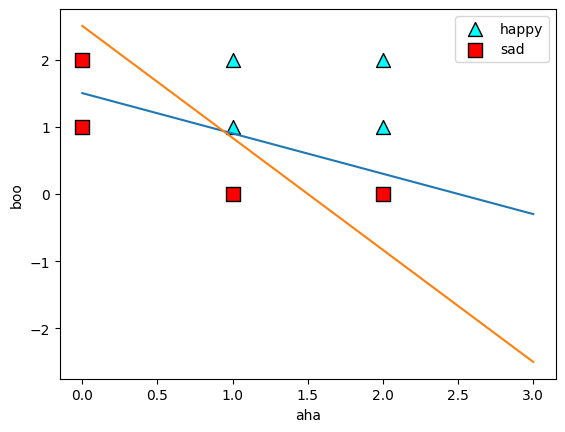

In [ ]:
plot_points(X, y, point_size=100)
draw_line(6,10,-15)
draw_line(10,6,-15)

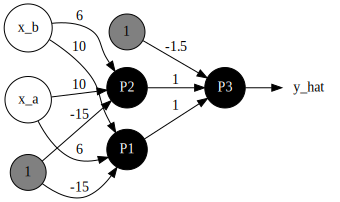

In [ ]:
# the neuro-net
g = graphviz.Digraph(format='svg', graph_attr={'rankdir': 'LR'})
g.node('xa', 'x_a', shape='circle')
g.node('xb', 'x_b', shape='circle')
g.node('b1', '1', shape='circle', style='filled', fillcolor='grey')
g.node('b2', '1', shape='circle', style='filled', fillcolor='grey')
g.node('p1', 'P1', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p2', 'P2', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('p3', 'P3', shape='circle', style='filled', fillcolor='black', fontcolor='white')
g.node('output', 'y_hat', shape='none')

g.edge('xa', 'p1', label='6')
g.edge('xa', 'p2', label='10')
g.edge('xb', 'p1', label='10')
g.edge('xb', 'p2', label='6')
g.edge('b1', 'p1', label='-15')
g.edge('b1', 'p2', label='-15')

g.edge('p1', 'p3', label='1')
g.edge('p2', 'p3', label='1')
g.edge('b2', 'p3', label='-1.5')

g.edge('p3', 'output')
g

In [ ]:
def step(x):
  if x >= 0:
    return 1
  else:
    return 0

def line_1(a,b):
  return step(6*a + 10*b - 15)

def line_2(a,b):
  return step(10*a + 6*b - 15)

def bias(a,b):
  return 1

def nn_with_step(a,b):
  return step(step(6*a + 10*b - 15) + step(10*a + 6*b - 15) - 1.5)

def sigmoid(x):
  return np.exp(x)/(1.0 + np.exp(x))

def nn_with_sigmoid(a,b):
  return sigmoid(1.0*sigmoid(6*a + 10*b - 15) + 1.0*sigmoid(10*a + 6*b - 15) - 1.5)

def plot_function(f, ax=None):
  plot_points(X, y, 100, ax)

  def h(x,y): # height function of the contour
    return f(x,y)>=0.5
  xx, yy = np.meshgrid(np.arange(-0.5,3,0.005),
                       np.arange(-0.5,3,0.005))
  Z = np.array([h(i[0], i[1]) for i in np.c_[xx.ravel(), yy.ravel()]])
  Z = Z.reshape(xx.shape)
  if ax is None:
    plt.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    plt.contour(xx, yy, Z,colors = 'k',linewidths = 3)
  else:
    ax.contourf(xx, yy, Z, colors=['red', 'blue'], alpha=0.25, levels=range(-1,2))
    ax.contour(xx, yy, Z,colors = 'k',linewidths = 3)


## Boundaries of NN 1st layer
1st layer of the neuro-net

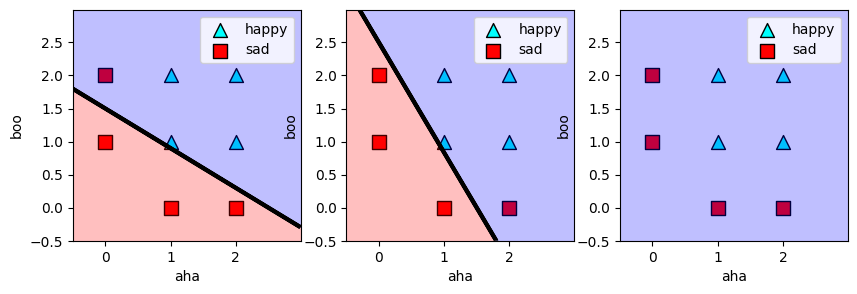

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
plot_function(line_1, ax1)
plot_function(line_2, ax2)
plot_function(bias, ax3)

## Boundaries of NN 2nd layer

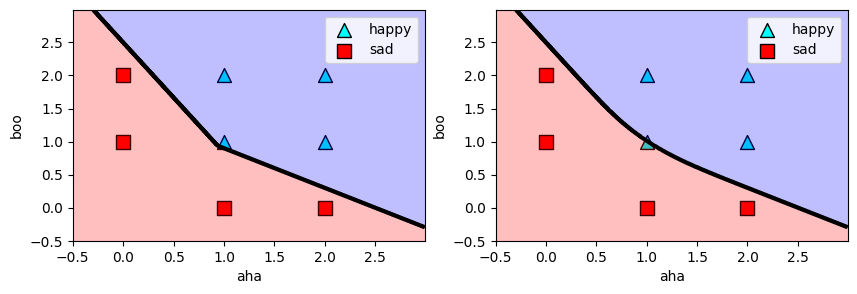

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,3))
plot_function(nn_with_step, ax1)
plot_function(nn_with_sigmoid, ax2)

# One-Circle Example

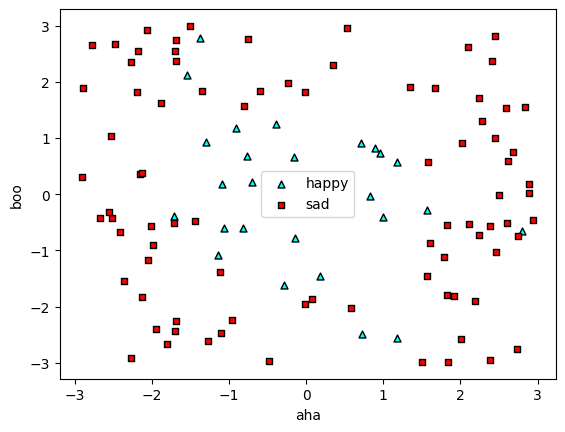

In [ ]:
df = pd.read_csv('data/one_circle.csv', index_col=0)
X = np.array(df[['x_1', 'x_2']])
y = np.array(df['y']).astype(int)
plot_points(X,y)

In [ ]:
X.shape, y.shape

((110, 2), (110,))

## Tensorflow
Implement the example using Tensorflow

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical

# turn y (0 or 1) into one-hot, i.e. [0,1] and [1,0]
categorised_y = np.array(to_categorical(y, 2))

# dimensions of the nero-net
# input: (2,), hidden layer 1 (128,), hidden 2 (64,), output (2,)
# activation fn: hidden layers: ReLU, output layer: Softmax
# dropout in hidden layers, ratio 0.2
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(2,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', # multi-value version of log loss
              optimizer='adam',
              metrics=['accuracy'])

# train the model
model.fit(X, categorised_y, epochs=100, batch_size=10)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6589 - loss: 0.5730
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7544 - loss: 0.4234 
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7446 - loss: 0.4775 
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7861 - loss: 0.4542 
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7694 - loss: 0.4404 
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7520 - loss: 0.4348 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7486 - loss: 0.4472  
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7315 - loss: 0.4642 
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7929 - loss: 0.4086 
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7166 - loss: 0.4722 
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7184 - loss: 0.4379 
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,312 (102.79 KB)

 Trainable params: 8,770 (34.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,542 (68.53 KB)

In [ ]:
categorised_y

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

## PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

class OneCircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(2, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 2)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    # x = F.relu(self.fc3(x))
    x = F.softmax(self.fc3(x), dim=1)
    return x

# prepare data
batch_size=10
categorised_y = F.one_hot(torch.tensor(y), 2).float()
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32),
                        categorised_y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# create model
model2 = OneCircleModel()
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 100
for epoch in range(num_epochs):
  model2.train()

  for features, labels in dataloader:
    outputs = model2(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


Epoch [0/100], loss: 0.6159
Epoch [1/100], loss: 0.4381
Epoch [2/100], loss: 0.4895
Epoch [3/100], loss: 0.5007
Epoch [4/100], loss: 0.5175
Epoch [5/100], loss: 0.6360
Epoch [6/100], loss: 0.3596
Epoch [7/100], loss: 0.4828
Epoch [8/100], loss: 0.4235
Epoch [9/100], loss: 0.4802
Epoch [10/100], loss: 0.5148
Epoch [11/100], loss: 0.4775
Epoch [12/100], loss: 0.5932
Epoch [13/100], loss: 0.5235
Epoch [14/100], loss: 0.4318
Epoch [15/100], loss: 0.4471
Epoch [16/100], loss: 0.3984
Epoch [17/100], loss: 0.5376
Epoch [18/100], loss: 0.3385
Epoch [19/100], loss: 0.4605
Epoch [20/100], loss: 0.3927
Epoch [21/100], loss: 0.3855
Epoch [22/100], loss: 0.3348
Epoch [23/100], loss: 0.4181
Epoch [24/100], loss: 0.3610
Epoch [25/100], loss: 0.4476
Epoch [26/100], loss: 0.4263
Epoch [27/100], loss: 0.4581
Epoch [28/100], loss: 0.3282
Epoch [29/100], loss: 0.3726
Epoch [30/100], loss: 0.3796
Epoch [31/100], loss: 0.4425
Epoch [32/100], loss: 0.3611
Epoch [33/100], loss: 0.4230
Epoch [34/100], loss: 0.

In [ ]:
# pytorch using Sequential
dropout_rate=0.0 # without dropout it's deterministic: the contour plot looks the same every time
model3 = nn.Sequential(
  nn.Linear(2, 128),
  nn.ReLU(),
  nn.Dropout(p=dropout_rate),
  nn.Linear(128, 64),
  nn.ReLU(),
  nn.Dropout(p=dropout_rate),
  nn.Linear(64, 2),
  nn.Softmax(dim=1)
)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model3.parameters(), lr=0.001)
for epoch in range(num_epochs):
  model3.train()

  for features, labels in dataloader:
    outputs = model3(features)
    loss = criterion(outputs, labels)

    # back prop
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")


Epoch [0/100], loss: 0.4772
Epoch [1/100], loss: 0.5881
Epoch [2/100], loss: 0.6771
Epoch [3/100], loss: 0.5524
Epoch [4/100], loss: 0.4263
Epoch [5/100], loss: 0.5076
Epoch [6/100], loss: 0.4571
Epoch [7/100], loss: 0.4593
Epoch [8/100], loss: 0.5018
Epoch [9/100], loss: 0.3847
Epoch [10/100], loss: 0.4815
Epoch [11/100], loss: 0.5142
Epoch [12/100], loss: 0.3893
Epoch [13/100], loss: 0.4625
Epoch [14/100], loss: 0.3695
Epoch [15/100], loss: 0.5824
Epoch [16/100], loss: 0.4110
Epoch [17/100], loss: 0.3276
Epoch [18/100], loss: 0.4260
Epoch [19/100], loss: 0.3487
Epoch [20/100], loss: 0.3662
Epoch [21/100], loss: 0.3252
Epoch [22/100], loss: 0.4261
Epoch [23/100], loss: 0.4614
Epoch [24/100], loss: 0.3191
Epoch [25/100], loss: 0.3712
Epoch [26/100], loss: 0.4872
Epoch [27/100], loss: 0.3315
Epoch [28/100], loss: 0.5244
Epoch [29/100], loss: 0.3175
Epoch [30/100], loss: 0.5724
Epoch [31/100], loss: 0.3257
Epoch [32/100], loss: 0.3393
Epoch [33/100], loss: 0.4261
Epoch [34/100], loss: 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


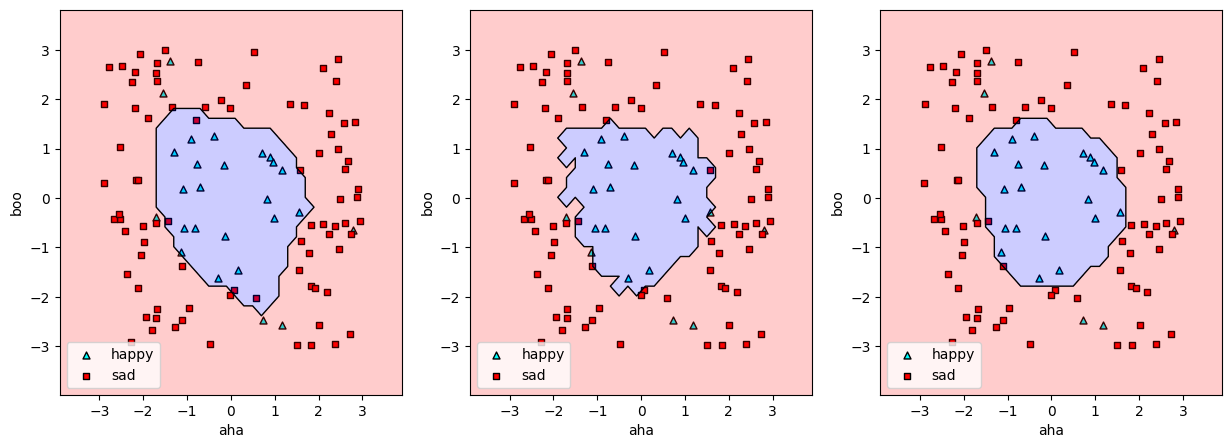

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
plot_keras_model(X, y, model, ax1)
plot_torch_model(X, y, model2, ax2)
plot_torch_model(X, y, model3, ax3)

In [ ]:
model(torch.tensor([[-1.0, -3.0]])), model(torch.tensor([[0.0, 0.0]]))

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.9981641 , 0.00183595]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.0341051 , 0.96589494]], dtype=float32)>)

In [ ]:
with torch.no_grad():
  out1 = model2(torch.tensor([[-1.0, -3.0]]))
  out2 = model2(torch.tensor([[0.0, 0.0]]))
  out3 = model3(torch.tensor([[-1.0, -3.0]]))
  out4 = model3(torch.tensor([[0.0, 0.0]]))
out1, out2, out3, out4

(tensor([[1.0000e+00, 6.5872e-09]]),
 tensor([[6.4586e-04, 9.9935e-01]]),
 tensor([[1.0000e+00, 2.1768e-10]]),
 tensor([[6.5170e-04, 9.9935e-01]]))

# House price example

In [ ]:
df = pd.read_csv('data/Hyderabad.csv')
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


In [ ]:
df['Location'].nunique()

243

In [ ]:
# turn the location strings into numbers

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
label_encoder = LabelEncoder()
df['Loc'] = label_encoder.fit_transform(df['Location'])
scaler = MinMaxScaler()
df['Area_scaled'] = scaler.fit_transform(df[['Area']])
df['Loc_scaled'] = scaler.fit_transform(df[['Loc']])
df

,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,...,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Loc,Area_scaled,Loc_scaled
0,6968000,1340,Nizampet,2,0,0,1,1,1,1,...,0,0,0,0,0,0,0,162,0.094382,0.669421
1,29000000,3498,Hitech City,4,0,0,1,1,1,1,...,0,0,0,0,0,0,0,85,0.336854,0.351240
2,6590000,1318,Manikonda,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,132,0.091910,0.545455
3,5739000,1295,Alwal,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,9,0.089326,0.037190
4,5679000,1145,Kukatpally,2,0,0,0,0,1,0,...,0,0,0,0,0,0,0,118,0.072472,0.487603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,11000000,1460,Nacharam,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,150,0.107865,0.619835
2514,26000000,1314,Manikonda,2,1,9,9,9,9,9,...,9,9,9,9,9,9,9,132,0.091461,0.545455
2515,13300000,2625,Madhapur,3,1,9,9,9,9,9,...,9,9,9,9,9,9,9,124,0.238764,0.512397
2516,10800000,2050,Hitech City,3,0,9,9,9,9,9,...,9,9,9,9,9,9,9,85,0.174157,0.351240


In [ ]:
features = df.drop(['Location', 'Price', 'Area', 'Loc'], axis=1)
labels = df['Price'].astype(float)
features

,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,...,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,Area_scaled,Loc_scaled
0,2,0,0,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0.094382,0.669421
1,4,0,0,1,1,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0.336854,0.351240
2,2,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0.091910,0.545455
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.089326,0.037190
4,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0.072472,0.487603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.107865,0.619835
2514,2,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.091461,0.545455
2515,3,1,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.238764,0.512397
2516,3,0,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,0.174157,0.351240


In [ ]:
from sklearn.model_selection import train_test_split
# Split the DataFrame into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

features.shape, labels.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2518, 39), (2518,), (2014, 39), (504, 39), (2014,), (504,))

## in Tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

# Building the model
house_model = Sequential()
house_model.add(Dense(features.shape[1], activation='relu', input_shape=(features.shape[1],)))
house_model.add(Dropout(.2))
house_model.add(Dense(128, activation='relu'))
house_model.add(Dropout(.2))
house_model.add(Dense(64, activation='relu'))
house_model.add(Dropout(.2))
house_model.add(Dense(1))

optimiser = tf.keras.optimizers.Adamax(learning_rate=0.1)
# Compiling the model. The metrics flag is added for the model to report the root mean squared error at each epoch.
house_model.compile(loss = 'mean_squared_error', optimizer=optimiser, metrics=[keras.metrics.RootMeanSquaredError()])
house_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                     │ (None, 39)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 39)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 128)                 │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001 (58.60 KB)

 Trainable params: 15,001 (58.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
house_model.fit(X_train, y_train, epochs=100, batch_size=10)

Epoch 1/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 148173637025792.0000 - root_mean_squared_error: 12082530.0000
Epoch 2/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 57224080654336.0000 - root_mean_squared_error: 7500585.0000
Epoch 3/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 69546446684160.0000 - root_mean_squared_error: 8306575.5000
Epoch 4/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 46706880151552.0000 - root_mean_squared_error: 6812026.5000
Epoch 5/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 45265528553472.0000 - root_mean_squared_error: 6651617.0000
Epoch 6/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 73035415552000.0000 - root_mean_squared_error: 8341202.5000
Epoch 7/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 43888031039488.0000 - root_mean_squared_error: 6596625.5000
Epoch 8/100
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49957407031296.0000 - root_mean_squared_error: 6980221.5000
Epoch 9/100
202/202 ━━━━━━━━━━

In [ ]:
house_model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18146222145536.0000 - root_mean_squared_error: 4169203.7500 


[18759559413760.0, 4331230.5]

In [ ]:
preds = house_model.predict(X_test)
preds.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


(504, 1)

In [ ]:
err = preds.flatten() - y_test.to_numpy()
err_percent = np.abs(((err)/y_test.to_numpy()))
err_percent.sort()
err_percent.min(), err_percent.max()

(0.0007943333333333333, 2.850955909090909)

In [ ]:
rms = tf.sqrt(tf.reduce_mean(tf.square(err)))
rms_percent = rms / tf.reduce_mean(y_test)
rms, rms_percent

(<tf.Tensor: shape=(), dtype=float64, numpy=4331230.456022903>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.4457434224585246>)

## In PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

class RMSELoss(nn.Module):
  def __init__(self, eps=1e-6):
    super().__init__()
    self.mse = nn.MSELoss()
    self.eps = eps

  def forward(self,yhat,y):
    loss = torch.sqrt(self.mse(yhat,y) + self.eps)
    return loss

dropout_rate = 0.2
house_model2 = nn.Sequential(
    nn.Linear(features.shape[1], 128),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(64, 1)
)
house_model2

Sequential(
  (0): Linear(in_features=39, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
Xt_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
yt_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
Xt_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
yt_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

dataset_train = TensorDataset(torch.tensor(Xt_train, dtype=torch.float32),
                        yt_train)
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# train
num_epochs = 100
criterion = RMSELoss()
optimiser = optim.Adamax(house_model2.parameters(), lr=0.1)
for epoch in range(num_epochs):
  house_model2.train()

  for feature, label in dataloader:
    pred = house_model2(feature).squeeze()
    loss = criterion(pred, label)

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  print(f"Epoch [{epoch}/{num_epochs}], loss: {loss.item():.4f}")

<ipython-input-304-58fc5bf0a774>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_train = TensorDataset(torch.tensor(Xt_train, dtype=torch.float32),


Epoch [0/100], loss: 1404544.7500
Epoch [1/100], loss: 2239520.2500
Epoch [2/100], loss: 1894050.1250
Epoch [3/100], loss: 478057.4688
Epoch [4/100], loss: 733294.7500
Epoch [5/100], loss: 1074528.8750
Epoch [6/100], loss: 1396669.0000
Epoch [7/100], loss: 861358.3750
Epoch [8/100], loss: 1650310.7500
Epoch [9/100], loss: 607021.0000
Epoch [10/100], loss: 2321891.5000
Epoch [11/100], loss: 36985624.0000
Epoch [12/100], loss: 1391320.0000
Epoch [13/100], loss: 1935408.0000
Epoch [14/100], loss: 2560649.7500
Epoch [15/100], loss: 1479583.3750
Epoch [16/100], loss: 1744282.0000
Epoch [17/100], loss: 1654826.0000
Epoch [18/100], loss: 780022.4375
Epoch [19/100], loss: 3009764.5000
Epoch [20/100], loss: 2252979.2500
Epoch [21/100], loss: 624661.8125
Epoch [22/100], loss: 4617128.0000
Epoch [23/100], loss: 3825521.2500
Epoch [24/100], loss: 7990877.5000
Epoch [25/100], loss: 685172.6250
Epoch [26/100], loss: 2464886.2500
Epoch [27/100], loss: 5623185.0000
Epoch [28/100], loss: 2181449.5000
E

In [ ]:
dataset_test = TensorDataset(torch.tensor(Xt_test, dtype=torch.float32),
                        yt_test)
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

house_model2.eval()
with torch.no_grad():
  total_loss = 0
  for feature, label in dataloader:
    pred = house_model2(feature).squeeze()
    loss = criterion(pred, label)
    total_loss += loss

  avg_loss = total_loss / len(dataloader)
  print(f"Average RMSE on test dataset: {avg_loss:.4f}")

Average RMSE on test dataset: 3152270.0000


<ipython-input-305-741d035f8d32>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset_test = TensorDataset(torch.tensor(Xt_test, dtype=torch.float32),


In [ ]:
preds2= house_model2(Xt_test)
err2 = preds2.squeeze() - yt_test
err_percent2 = err2 / yt_test
print(f"min={err_percent2.abs().min()}, max={err_percent2.abs().max()}")
err_percent2 = np.abs(err_percent2.detach().numpy())
err_percent2.sort()


min=0.00038406249950639904, max=2.8391218185424805


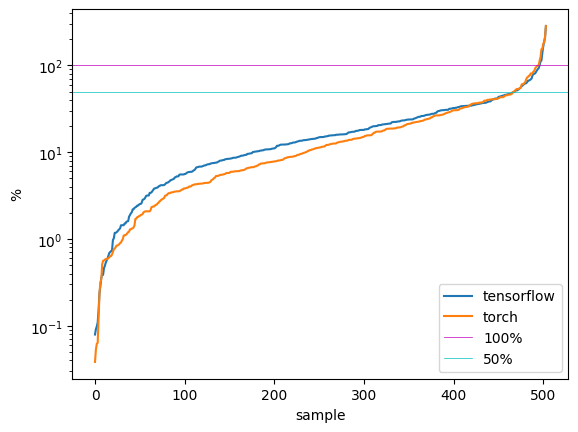

In [ ]:
plt.plot(err_percent*100, label='tensorflow')
plt.plot(err_percent2*100, label='torch')
plt.ylabel('%')
plt.yscale('log')
plt.xlabel('sample')
plt.axhline(y=100, color='m', label='100%', lw=0.5)
plt.axhline(y=50, color='c', label='50%', lw=0.5)
plt.legend()

In [ ]:

rmse = torch.mean(torch.sqrt(torch.mean(err**2)))
rmse

tensor(8796091., grad_fn=<MeanBackward0>)

# MNIST example

## in Tensorflow

In [331]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_reshaped = X_train.reshape(-1, 28*28)
X_test_reshaped = X_test.reshape(-1, 28*28)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, \
X_train_reshaped.shape, X_test_reshaped.shape

((60000, 28, 28),
 (60000,),
 (10000, 28, 28),
 (10000,),
 (60000, 784),
 (10000, 784))

In [335]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cal = to_categorical(y_test)

y_train_cat.shape, y_test_cat.shape, y_train_cat[0]

((60000, 10), (10000, 10), array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]))

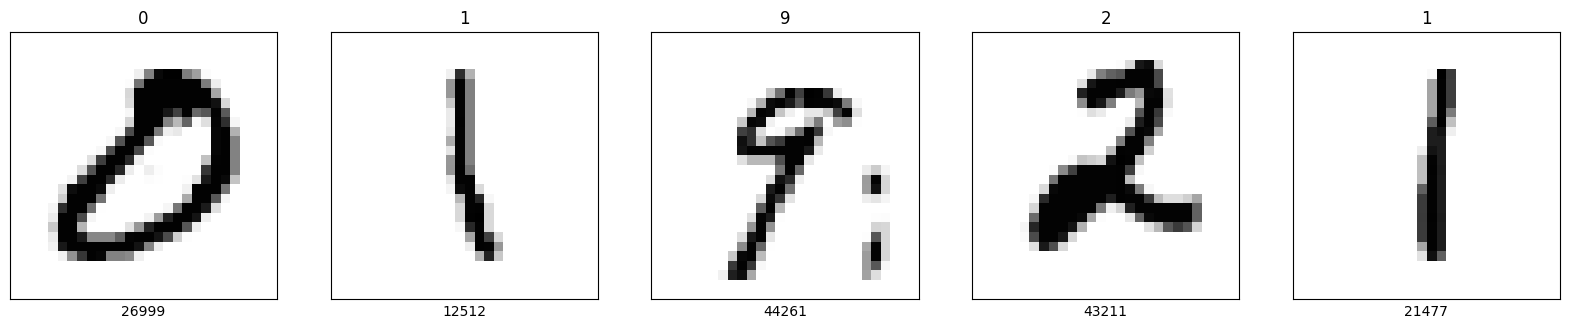

In [339]:
import random

fig = plt.figure(figsize=(20,20))
for i in range(5):
  idx = random.randint(0, len(X_train))
  ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
  ax.imshow(X_train[idx], cmap='Greys')
  ax.set_title(y_train[idx])
  ax.set_xlabel(idx)